#Project 2
###Youtube Content Moderation Using Transformers

David Membreno and Raphael Sampaio Rosa Altomar

##Imports

In [ ]:
##Imports Block
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

##Preprocessing

Here are the datasets we will be using

https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset

https://www.kaggle.com/datasets/ahsenwaheed/youtube-comments-spam-dataset

https://www.kaggle.com/datasets/reihanenamdari/youtube-toxicity-data

It will be uploaded to GitHub and loaded into this notebook

In [ ]:
File1 = "https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/YoutubeCommentsDataSet.csv"
File2 = "https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/Youtube-Spam-Dataset.csv"
File3 = "https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/youtoxic_english_1000.csv"

In [ ]:
df1 = pd.read_csv(File1)
df2 = pd.read_csv(File2)
df3 = pd.read_csv(File3)

In [ ]:
#dropping unecessary columns
df1 = df1.drop(['Sentiment'], axis=1)
df2 = df2['CONTENT']
df3 = df3['Text']

In [ ]:
df2 = pd.DataFrame(df2)
df3 = pd.DataFrame(df3)

In [ ]:
#Rename all columns in all dfs to "Comments"
df2['Comment'] =df2 ['CONTENT']
df2.drop('CONTENT', axis=1, inplace=True)
df3['Comment'] = df3['Text']
df3.drop('Text', axis=1, inplace=True)

In [ ]:
#join all 3
df = pd.concat([df1, df2, df3])

In [ ]:
#row nums for each to check that we correctly added together the data
check = len(df1)+len(df2)+len(df3)

print(check == len(df))
#The number of rows/obersvations we have now in total
print("We have ", len(df), "rows of data")


True
We have  21364 rows of data


In [ ]:
df.head()

,Comment
0,lets not forget that apple pay in 2014 require...
1,here in nz 50 of retailers don’t even have con...
2,i will forever acknowledge this channel with t...
3,whenever i go to a place that doesn’t take app...
4,apple pay is so convenient secure and easy to ...


In [ ]:
#lets drop NA or Null
df = df.dropna()
len(df)

21320

We are ready to continue with applying transformers now

In [ ]:
#Here I will include a few short code snippets to avoid all preprocessing/concat-
#We are saving our data to CSV format and uploading it to my repo

# import csv
# import pandas as pd

# csv_file_path = 'CompleteYoutubeCommentsData.csv'
# df.to_csv(csv_file_path, index=False)

# from google.colab import files
# files.download(csv_file_path)

##Model Evaluation/Decision

Before applying our transformer to the full combined dataset, we evaluated its accuracy using one of our original labeled datasets (`df3`), which contains a toxicity label. This allowed us to verify the model’s behavior and ensure that its predictions were reasonable

###unitary/toxic-bert

In [ ]:
File3 = "https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/youtoxic_english_1000.csv"
df3 = pd.read_csv(File3)
df3 = df3.dropna()

In [ ]:
df3['Text'] = df3['Text'].astype(str)
df3['Text_trunc'] = df3['Text'].apply(lambda x: x[:512])# we had to do this since BERT limits its token size to 215

In [ ]:
# Load the transformer pipeline
from transformers import pipeline
classifier = pipeline("text-classification", model="unitary/toxic-bert")


def predict_toxicity(text):
    results = classifier(text)
    return 'toxicity' if any(res['label'] == 'toxicity' and res['score'] > 0.3 for res in results) else 'non-toxic'


from tqdm import tqdm
tqdm.pandas()
df3['bert_pred'] = df3['Text_trunc'].progress_apply(predict_toxicity)

df3['true_label'] = df3['IsToxic'].apply(lambda x: 'toxicity' if x == 1 else 'non-toxic')

# Evaluate the model
from sklearn.metrics import classification_report
print(classification_report(df3['true_label'], df3['bert_pred']))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

              precision    recall  f1-score   support

   non-toxic       0.54      1.00      0.70       538
    toxicity       0.00      0.00      0.00       462

    accuracy                           0.54      1000
   macro avg       0.27      0.50      0.35      1000
weighted avg       0.29      0.54      0.38      1000



Hmm, this is definitely not what I had in mind for accuracy. Perhaps another model will perform better.

###martin-ha/toxic-comment-model

In [ ]:
## Evaluation on df3 – Using 'martin-ha/toxic-comment-model'

File3 = "https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/youtoxic_english_1000.csv"
df3 = pd.read_csv(File3)

df3 = df3.dropna(subset=['Text', 'IsToxic'])
df3['Text'] = df3['Text'].astype(str)
df3['Text_trunc'] = df3['Text'].apply(lambda x: x[:512])

from transformers import pipeline
classifier = pipeline("text-classification", model="martin-ha/toxic-comment-model")

def predict_toxicity(text, threshold=0.5):
    results = classifier(text)
    return 'toxicity' if results[0]['label'].lower() == 'toxic' and results[0]['score'] > threshold else 'non-toxic'

from tqdm import tqdm
tqdm.pandas()
df3['bert_pred'] = df3['Text_trunc'].progress_apply(lambda x: predict_toxicity(x, threshold=0.5))

df3['true_label'] = df3['IsToxic'].apply(lambda x: 'toxicity' if x == 1 else 'non-toxic')

from sklearn.metrics import classification_report
print(classification_report(df3['true_label'], df3['bert_pred']))


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/403 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 1000/1000 [01:43<00:00,  9.64it/s]

              precision    recall  f1-score   support

   non-toxic       0.69      0.86      0.76       538
    toxicity       0.77      0.55      0.64       462

    accuracy                           0.71      1000
   macro avg       0.73      0.70      0.70      1000
weighted avg       0.73      0.71      0.71      1000



###JungleLee/bert-toxic-comment-classification

In [ ]:
## Evaluation on df3 – Using 'JungleLee/bert-toxic-comment-classification'

File3 = "https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/youtoxic_english_1000.csv"
df3 = pd.read_csv(File3)

df3 = df3.dropna(subset=['Text', 'IsToxic'])
df3['Text'] = df3['Text'].astype(str)
df3['Text_trunc'] = df3['Text'].apply(lambda x: x[:512])


from transformers import pipeline
classifier = pipeline("text-classification", model="JungleLee/bert-toxic-comment-classification")

def predict_toxicity_jungle(text, threshold=0.5):
    result = classifier(text)[0]
    return 'toxicity' if result['label'].lower() == 'toxic' and result['score'] > threshold else 'non-toxic'

from tqdm import tqdm
tqdm.pandas()
df3['bert_pred'] = df3['Text_trunc'].progress_apply(lambda x: predict_toxicity_jungle(x, threshold=0.5))

df3['true_label'] = df3['IsToxic'].apply(lambda x: 'toxicity' if x == 1 else 'non-toxic')

# Evaluate model performance
from sklearn.metrics import classification_report
print(classification_report(df3['true_label'], df3['bert_pred']))


KeyboardInterrupt: 

###s-nlp/roberta_toxicity_classifier

In [ ]:
## Evaluation on df3 – Using 's-nlp/roberta_toxicity_classifier'

import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pandas as pd
from sklearn.metrics import classification_report
from tqdm import tqdm

# Load the model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('s-nlp/roberta_toxicity_classifier')
model = RobertaForSequenceClassification.from_pretrained('s-nlp/roberta_toxicity_classifier')
model.eval()  # Set model to evaluation mode

File3 = "https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/youtoxic_english_1000.csv"
df3 = pd.read_csv(File3)
df3 = df3.dropna(subset=['Text', 'IsToxic'])
df3['Text'] = df3['Text'].astype(str)
df3['Text_trunc'] = df3['Text'].apply(lambda x: x[:512])

def predict_toxicity_snlp(text, threshold=0.5):
    inputs = tokenizer.encode(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        logits = model(inputs).logits
        probs = torch.softmax(logits, dim=1)
        toxic_prob = probs[0][1].item()
    return 'toxicity' if toxic_prob > threshold else 'non-toxic'


tqdm.pandas()
df3['bert_pred'] = df3['Text_trunc'].progress_apply(lambda x: predict_toxicity_snlp(x, threshold=0.5))
df3['true_label'] = df3['IsToxic'].apply(lambda x: 'toxicity' if x == 1 else 'non-toxic')

print(classification_report(df3['true_label'], df3['bert_pred']))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s]

              precision    recall  f1-score   support

   non-toxic       0.78      0.86      0.82       538
    toxicity       0.82      0.72      0.77       462

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.80      0.80      0.80      1000



**Model Comparison and Final Selection**

We used df3 which already has a toxicity label we can test on


1.   **unitary/toxic-bert**


 - Accuracy: 54%  
 - Detected no toxic comments (0% recall, 0% precision for toxicity)  
 - Not usable for our project


2.   **martin-ha/toxic-comment-model**
 - Accuracy: 71%  
   - F1-Score (Toxicity): 0.64  
   - showed a tendency to miss toxic comments (recall: 0.55)

3. **JungleLee/bert-toxic-comment-classification**  
   - Accuracy: 75%  
   - F1-Score (Toxicity): 0.74  
   - performed significantly better overall

4. **s-nlp/roberta_toxicity_classifier** (**Selected Model**)  
   - Accuracy: **80%**  
   - F1-Score (Toxicity): **0.77**  
   - Achieved the best overall performance with strong precision, recall, and balance between classes

**Conclusion**:  

We selected **s-nlp/roberta_toxicity_classifier** as our final model. It  delivered the highest accuracy (80%) but also maintained strong performance in both detecting toxicity and avoiding false positives.

##Access Complete Cleaned Data
###**Run this and Imports first and avoid running preprocessing section**

In [ ]:
#Reloading our dataset (Run this whenever reopening the notebook prior to transformer usage)
#import https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/CompleteYoutubeCommentsData.csv
import pandas as pd
df = pd.read_csv('https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/CompleteYoutubeCommentsData.csv')
len(df)

21320

##Transformer Applications

The specific transformer model we are using is **RoBERTa** (s-nlp/roberta_toxicity_classifier). RoBERTa is a highly optimized version of BERT developed by Facebook AI. Like BERT, it is a bidirectional model, meaning it considers the full context of a sentence when making predictions, rather than just processing left-to-right.

This particular model was fine-tuned  for toxicity detection using labeled comment data, making it perfect for filtering out harmful or abusive language in our YouTube comment data.

https://huggingface.co/docs/transformers/en/model_doc/roberta


In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tqdm import tqdm
import pandas as pd

In [ ]:
# Load model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('s-nlp/roberta_toxicity_classifier')
model = RobertaForSequenceClassification.from_pretrained('s-nlp/roberta_toxicity_classifier')
model.eval()

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# We have to truncate comments due to the limit f 512 for tokens
df['Comment'] = df['Comment'].astype(str)
df['Comment_trunc'] = df['Comment'].apply(lambda x: x[:512])

In [ ]:
batch_size = 64
comments = df['Comment_trunc'].tolist()
predictions = []
confidences = []

for i in tqdm(range(0, len(comments), batch_size)):
    batch_texts = comments[i:i+batch_size]
    inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)
        toxic_probs = probs[:, 1]

    for prob in toxic_probs:
        score = prob.item()
        label = 'toxicity' if score > 0.5 else 'non-toxic'
        predictions.append(label)
        confidences.append(score if label == 'toxicity' else 1 - score)

  5%|▌         | 18/334 [13:54<4:04:08, 46.36s/it]


KeyboardInterrupt: 

This model took almost 2 hrs to run with T4 GPU Runtime. For the sake of saving time I will be sending the csv of the results to a repo.

In [ ]:
df['prediction'] = predictions
df['confidence'] = confidences
df.to_csv("Predicted_YouTube_Comments.csv", index=False)

from google.colab import files
files.download("Predicted_YouTube_Comments.csv")

In [ ]:
df[['Comment', 'prediction', 'confidence']].sample(5)

##**Load Transformed Data Here!**

In [ ]:
file_link = "https://github.com/DavidMembreno/Data-Science/raw/refs/heads/main/Predicted_YouTube_Comments.csv"
df = pd.read_csv(file_link)
#rename toxicity entires to toxic
df['prediction'] = df['prediction'].replace('toxicity', 'toxic')
df.head()


,Comment,Comment_trunc,prediction,confidence
0,lets not forget that apple pay in 2014 require...,lets not forget that apple pay in 2014 require...,non-toxic,0.999966
1,here in nz 50 of retailers don’t even have con...,here in nz 50 of retailers don’t even have con...,non-toxic,0.999964
2,i will forever acknowledge this channel with t...,i will forever acknowledge this channel with t...,non-toxic,0.999944
3,whenever i go to a place that doesn’t take app...,whenever i go to a place that doesn’t take app...,non-toxic,0.999857
4,apple pay is so convenient secure and easy to ...,apple pay is so convenient secure and easy to ...,non-toxic,0.999960


In [ ]:
df.prediction.value_counts()

,count
prediction,
non-toxic,20468
toxic,852


In [ ]:
non_toxic_sample = df[df['prediction'] == 'non-toxic'].sample(n=852, random_state=42)
balanced_df = pd.concat([non_toxic_sample, df[df['prediction'] == 'toxic']])

Text(0.5, 1.0, 'Confidence Score Distribution by Prediction Class')

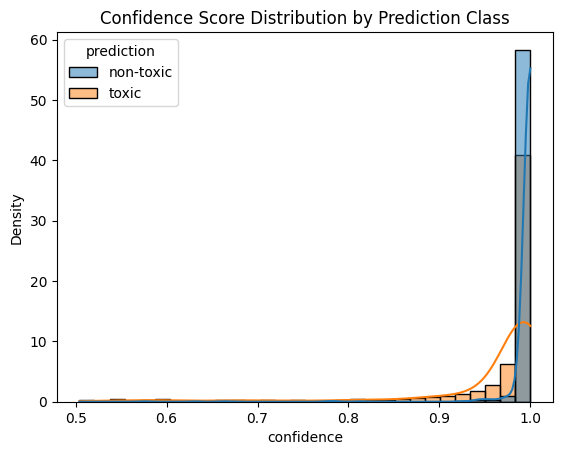

In [ ]:
import matplotlib.pyplot as plt
sns.histplot(data=balanced_df, x='confidence', hue='prediction', kde=True, stat='density', common_norm=False, bins=30)
plt.title("Confidence Score Distribution by Prediction Class")


##Link to Streamlit Website (Comment Checker)

https://commentchecker.streamlit.app/



QR Code for Website

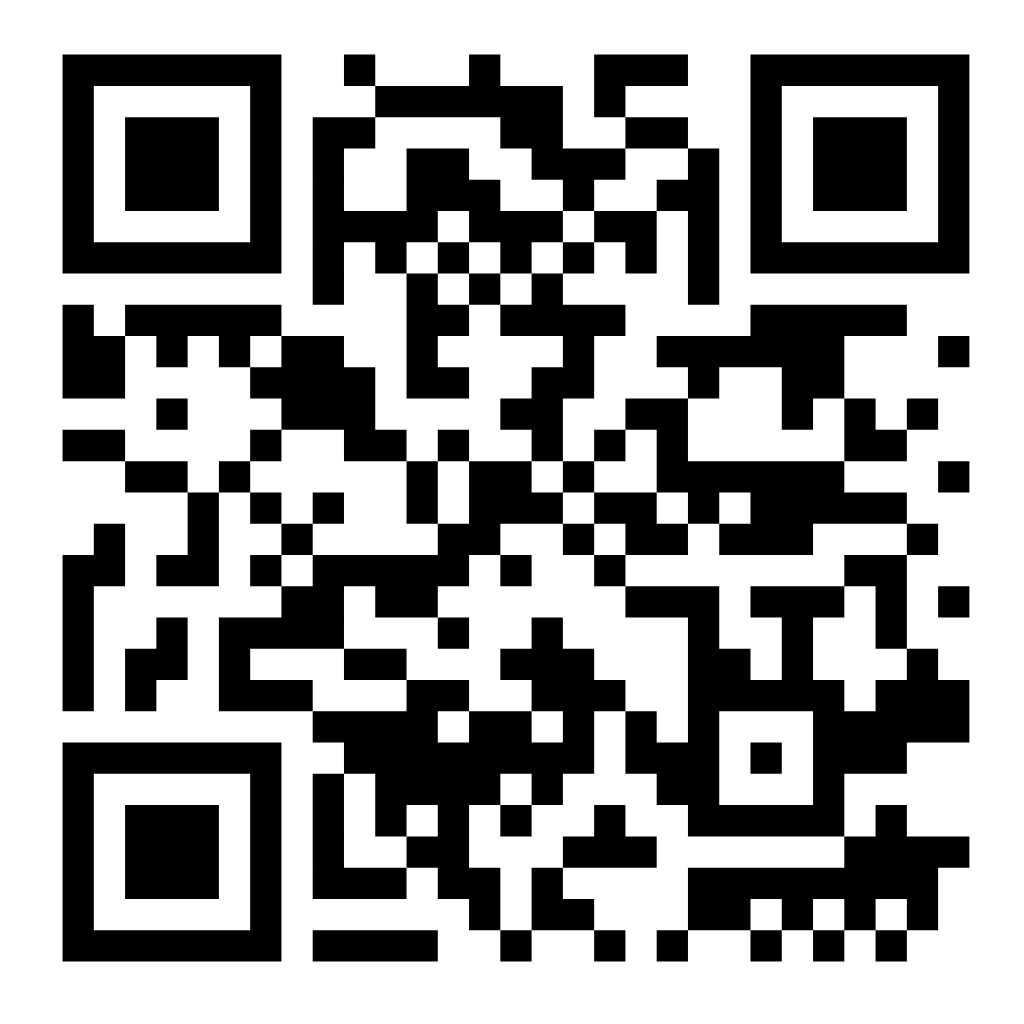

##Results and Visualizations

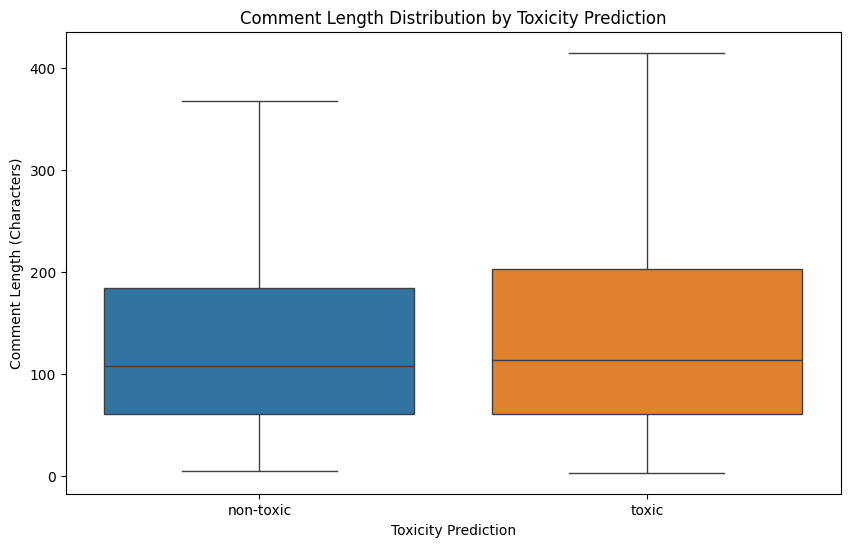

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate comment lengths (if not already calculated)
balanced_df['comment_length'] = balanced_df['Comment'].apply(len)

# Create box plot
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.boxplot(data=balanced_df, x='prediction', y='comment_length', hue='prediction', showfliers=False)
plt.title('Comment Length Distribution by Toxicity Prediction')
plt.xlabel('Toxicity Prediction')
plt.ylabel('Comment Length (Characters)')
plt.show()

In [ ]:
toxic_comment_lengths = balanced_df[balanced_df['prediction'] == 'toxic']['comment_length']
non_toxic_comment_lengths = balanced_df[balanced_df['prediction'] == 'non-toxic']['comment_length']

In [ ]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(toxic_comment_lengths, non_toxic_comment_lengths)

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 0.09439203270953181
P-value: 0.9248088552235887


The results of the t-test, with a p-value of 0.9248, suggest that the observed difference in comment lengths between toxic and non-toxic comments is likely due to random chance and not a true difference between the groups.

Based on this p-value, we conclude that there is no significant relationship between the length of a YouTube comment and its toxicity. The length of a comment, in this case, does not appear to be a useful predictor of whether a comment is toxic or not.

In [ ]:
!pip install nltk

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


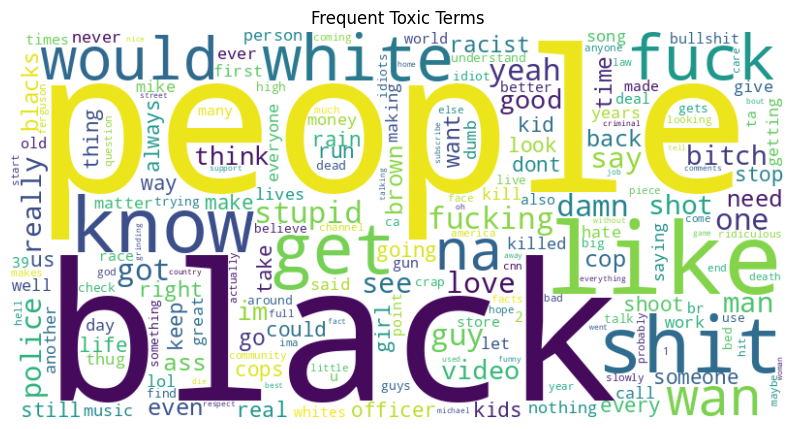

In [ ]:
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download the 'punkt_tab' resource
nltk.download('punkt_tab')
nltk.download('stopwords')


# Preprocess text data
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

toxic_comments = balanced_df[balanced_df['prediction'] == 'toxic']['Comment'].apply(preprocess_text).str.cat(sep=' ')

# Count word frequencies
word_counts = Counter(toxic_comments.split())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Toxic Terms')
plt.show()

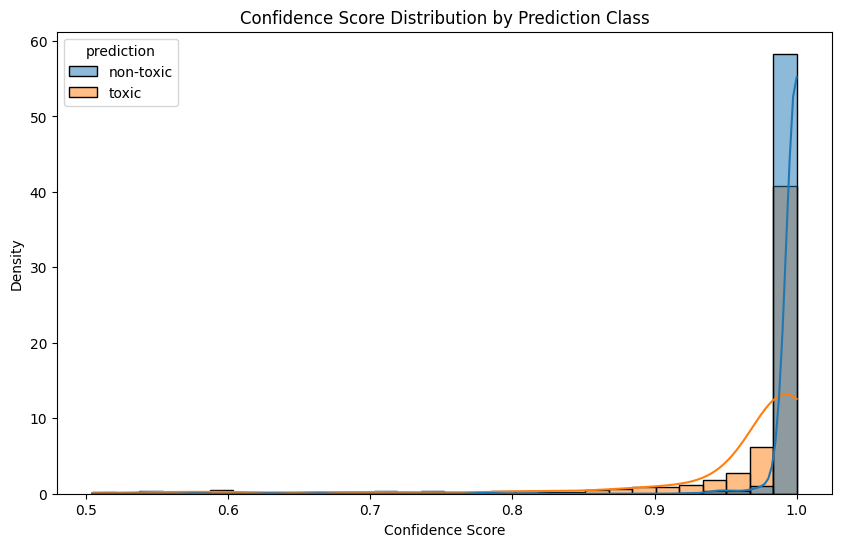

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.histplot(data=balanced_df, x='confidence', hue='prediction', kde=True, stat='density', common_norm=False, bins=30)
plt.title("Confidence Score Distribution by Prediction Class")
plt.xlabel('Confidence Score')
plt.ylabel('Density')
plt.show()

##Conclusion

Using three publicly available real YouTube comment datasets, we were able to evaluate several models and choose the one with the best precision and accuracy (RoBERTa).

From this model and our three datasets, we could then run our model on their combination and extract valuable meaning, as well as create an application as an example.

We found that around 4% of the comments in our combined dataset were labeled toxic. Comment length and the toxic vs. non-toxic classification had no strong correlation. Through our word cloud and analysis of the top 5 least and most toxic comments, we gained further insight into what categorizes one or the other.

Additionally, we were able to demonstrate an applied model rather than a static one—our application allows anyone to try out the model's classification ability.

We are left with several different paths after this project. We could create a multi-model algorithm for toxicity, sentiment, spam, and ad-based classification. We could also train our model on a larger and more comprehensive comment dataset to improve our results. Another option is to create a lighter version of the model or enable multilingual support. There are many ways to proceed from this project, but overall, our aim to classify toxic comments was met.

In [ ]:
Link to slides

[NbConvertApp] Converting notebook /content/Project_2_DATA440.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.11/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.11/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^